# Immothep
### *Orkaëlle & Thomas*

La société Immothep est une agence immobilière spécialisée dans le vente de biens de particuliers.

Possédant déjà un site internet, elle souhaite pouvoir intégrer à celui-ci, un module d'estimation. Elle possède les ressources nécessaires pour réaliser le code dit "front", ainsi que les ressources graphiques.

Elle ne possède cependant pas les compétences nécessaires pour la réalisation de l'API qui va permettre d'exposer ce nouveau service.

La société nous sollicite donc pour réaliser la partie API en utilisant les données Open Data des Demandes de Valeurs Foncières (DVF) sur l'année 2019.

## 0 - Initialisation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATAS_LOCAL_PATH = './DATAS/'
RAW_LOCAL_PATH = DATAS_LOCAL_PATH + 'RAW/'
TXT_LOCAL_PATH = RAW_LOCAL_PATH + 'valeursfoncieres-2019.txt'
CURATED_LOCAL_PATH = DATAS_LOCAL_PATH + 'CURATED/'
URL = 'https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2'

In [3]:
import immothep_fct as fct
import pandas as pd

In [4]:
surface = 43
nbpieces = 2
CP = 33000
terrain = 0

dpt = int(CP/1000)

In [5]:
fct.check_folder()
fct.ensure_data_loaded(dpt)

Datas already douwnloaded.
Datas already splited.


In [6]:
fichier = f'{CURATED_LOCAL_PATH}{str(dpt).zfill(2)}.csv'

# lecture du fichier raw
raw_df = pd.read_csv(fichier, decimal=',', encoding="UTF-8")

## 1 - Récuperation et nettoyage du Dataset

In [7]:
import numpy as np
import seaborn as sns
import csv

In [8]:
#création dataframe pandas avec les colonnes souhaitées
df = raw_df[["Nature mutation","Valeur fonciere","Nombre de lots","Code postal","Code departement","Code type local","Type local","Surface reelle bati","Surface Carrez du 1er lot","Nombre pieces principales","Surface terrain"]]

In [9]:
# Suppression ou mises à zéro des lignes vides
df.dropna(subset = ["Valeur fonciere"], inplace = True)
df.dropna(subset = ["Code postal"], inplace = True)
df.dropna(subset = ["Surface reelle bati"], inplace = True)
df.dropna(subset = ["Code departement"], inplace = True)
df['Surface terrain'] = df['Surface terrain'].fillna(0)
df.isnull().sum()

Nature mutation                  0
Valeur fonciere                  0
Nombre de lots                   0
Code postal                      0
Code departement                 0
Code type local                  0
Type local                       0
Surface reelle bati              0
Surface Carrez du 1er lot    40479
Nombre pieces principales        0
Surface terrain                  0
dtype: int64

In [10]:
# Suppression du département Corse pour éviter les str
df = df.drop(df.loc[(df["Code departement"] == "2A") | (df["Code departement"] == "2B")].index)

In [11]:
# Conversion en int
df["Code type local"] = df["Code type local"].astype('int8')
df["Code departement"] = df["Code departement"].astype('int8')

In [12]:
# Filrage sur les natures 'Ventes', et sur les 'Maisons' et 'Appartements'
df = df.loc[(df['Nature mutation'] == 'Vente') & ((df['Type local'] == 'Maison') | (df['Type local'] == 'Appartement'))]

In [13]:
# Suppression des ventes de lots multiples
df = df.drop(df.loc[df["Nombre de lots"]> 1].index)
df.groupby("Nombre de lots")[['Valeur fonciere']].count().sort_values("Nombre de lots")

,Valeur fonciere
Nombre de lots,
0,22884
1,9078


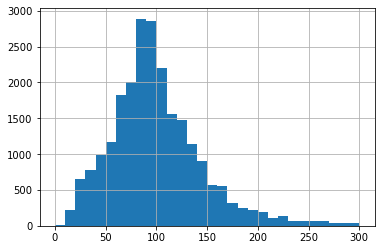

In [14]:
# Nettoyage des surfaces (suppression incohérence, choix de la plus appropriée, suppression des NA)
df = df.drop(df.loc[df["Surface Carrez du 1er lot"] > df["Surface reelle bati"]].index)
df['Surface'] = np.where(df["Code type local"] == 1, df["Surface reelle bati"],df["Surface Carrez du 1er lot"])
df.dropna(subset = ["Surface"], inplace = True)
df['Surface'].hist(bins=30, range=(0,300))

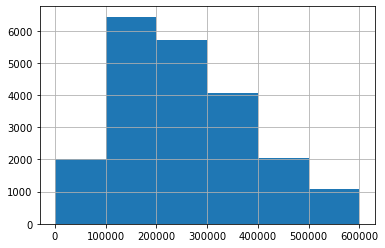

In [15]:
df['Valeur fonciere'].hist(bins=6, range=(0,600000))

In [16]:
# Creation colonne prix m²
df_prixmoyen = df.groupby('Code postal')[['Surface','Valeur fonciere']].sum().reset_index()
df_prixmoyen['Prix moyen m2 CP'] = round(df_prixmoyen['Valeur fonciere'] / df_prixmoyen['Surface'],0)
df_prixmoyen = df_prixmoyen[['Code postal','Prix moyen m2 CP']]
df = pd.merge(df, df_prixmoyen, on='Code postal')
df_prixmoyen.set_index('Code postal', inplace=True)
df.head(20)

,Nature mutation,Valeur fonciere,Nombre de lots,Code postal,Code departement,Code type local,Type local,Surface reelle bati,Surface Carrez du 1er lot,Nombre pieces principales,Surface terrain,Surface,Prix moyen m2 CP
0,Vente,165000.0,0,33480.0,33,1,Maison,70.0,NaN,4.0,970.0,70.00,3412.0
1,Vente,197000.0,0,33480.0,33,1,Maison,96.0,NaN,5.0,449.0,96.00,3412.0
2,Vente,129000.0,0,33480.0,33,1,Maison,130.0,NaN,5.0,0.0,130.00,3412.0
3,Vente,260000.0,0,33480.0,33,1,Maison,105.0,NaN,4.0,479.0,105.00,3412.0
4,Vente,258000.0,0,33480.0,33,1,Maison,93.0,NaN,4.0,738.0,93.00,3412.0
5,Vente,92000.0,0,33480.0,33,1,Maison,90.0,NaN,2.0,179.0,90.00,3412.0
6,Vente,470000.0,0,33480.0,33,1,Maison,177.0,NaN,5.0,17128.0,177.00,3412.0
7,Vente,470000.0,0,33480.0,33,1,Maison,177.0,NaN,5.0,13823.0,177.00,3412.0
8,Vente,470000.0,0,33480.0,33,1,Maison,177.0,NaN,5.0,854.0,177.00,3412.0
9,Vente,110000.0,0,33480.0,33,1,Maison,86.0,NaN,5.0,130.0,86.00,3412.0


## 2 - Isolation forest

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [18]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(df[['Valeur fonciere','Surface','Nombre pieces principales','Prix moyen m2 CP']])

IsolationForest(contamination=0.1, n_estimators=50)

In [19]:
# Ajouter une colonne de scores et d'anomalies
df['scores']=model.decision_function(df[['Valeur fonciere','Surface','Nombre pieces principales','Prix moyen m2 CP']])
df['anomaly']=model.predict(df[['Valeur fonciere','Surface','Nombre pieces principales','Prix moyen m2 CP']])
df.head(20)

,Nature mutation,Valeur fonciere,Nombre de lots,Code postal,Code departement,Code type local,Type local,Surface reelle bati,Surface Carrez du 1er lot,Nombre pieces principales,Surface terrain,Surface,Prix moyen m2 CP,scores,anomaly
0,Vente,165000.0,0,33480.0,33,1,Maison,70.0,NaN,4.0,970.0,70.00,3412.0,0.139969,1
1,Vente,197000.0,0,33480.0,33,1,Maison,96.0,NaN,5.0,449.0,96.00,3412.0,0.130543,1
2,Vente,129000.0,0,33480.0,33,1,Maison,130.0,NaN,5.0,0.0,130.00,3412.0,0.123534,1
3,Vente,260000.0,0,33480.0,33,1,Maison,105.0,NaN,4.0,479.0,105.00,3412.0,0.151101,1
4,Vente,258000.0,0,33480.0,33,1,Maison,93.0,NaN,4.0,738.0,93.00,3412.0,0.149699,1
5,Vente,92000.0,0,33480.0,33,1,Maison,90.0,NaN,2.0,179.0,90.00,3412.0,0.051549,1
6,Vente,470000.0,0,33480.0,33,1,Maison,177.0,NaN,5.0,17128.0,177.00,3412.0,0.090305,1
7,Vente,470000.0,0,33480.0,33,1,Maison,177.0,NaN,5.0,13823.0,177.00,3412.0,0.090305,1
8,Vente,470000.0,0,33480.0,33,1,Maison,177.0,NaN,5.0,854.0,177.00,3412.0,0.090305,1
9,Vente,110000.0,0,33480.0,33,1,Maison,86.0,NaN,5.0,130.0,86.00,3412.0,0.111912,1


In [20]:
# Print des divers Anomalies
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

      Nature mutation  Valeur fonciere  Nombre de lots  Code postal  \
11              Vente         276000.0               0      33480.0   
19              Vente         240000.0               0      33480.0   
36              Vente         159100.0               0      33480.0   
48              Vente         404750.0               0      33480.0   
58              Vente         225000.0               0      33480.0   
...               ...              ...             ...          ...   
23385           Vente         308500.0               0      33250.0   
23386           Vente         308500.0               0      33250.0   
23399           Vente         448605.0               0      33250.0   
23428           Vente          28980.0               1      33123.0   
23437           Vente          30000.0               1      33123.0   

       Code departement  Code type local   Type local  Surface reelle bati  \
11                   33                1       Maison                

In [21]:
# Évaluer le modèle
outliers_counter = len(df[df['Valeur fonciere'] > 699999]) + len(df[df['Valeur fonciere'] < 10000]) + len(df[df['Surface'] > 270]) + len(df[df['Surface'] < 10]) + len(df[df['Nombre pieces principales'] > 6]) + len(df[df['Nombre pieces principales'] < 1])
outliers_counter

2902

In [22]:
# Pourcentage de précision
print("Accuracy percentage:", 100*list(df['anomaly']).count(-1)/(outliers_counter))

Accuracy percentage: 80.94417643004824


## 3 - Matrice de correlation

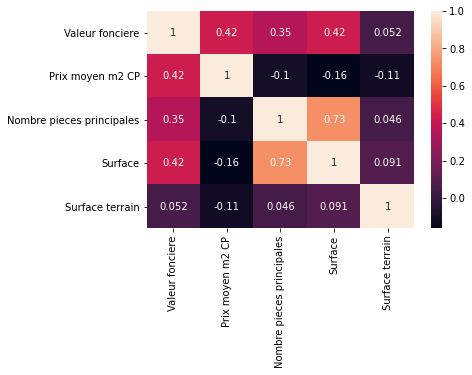

In [23]:
# Création de la matrice de correlation
df = df.loc[df['anomaly'] != -1]
df_matrice = df[["Valeur fonciere",'Prix moyen m2 CP',"Nombre pieces principales","Surface","Surface terrain"]]
matrice_corr = df_matrice.corr().round(3)
sns.heatmap(data=matrice_corr, annot=True)

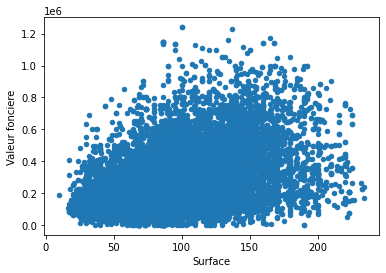

In [24]:
df.plot('Surface','Valeur fonciere', 'scatter')

## 3 - Entrainement

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [26]:
df_train = df.sample(n=3000, random_state=7)

In [27]:
X = pd.DataFrame(np.c_[df_train["Surface"],df_train["Nombre pieces principales"],df_train['Prix moyen m2 CP'],df_train['Surface terrain']], columns= ["Surface","Nombre pieces principales",'Prix moyen m2 CP',"Surface terrain"])
Y = df_train["Valeur fonciere"]

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2400, 4)
(600, 4)
(2400,)
(600,)


In [29]:
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

LinearRegression()

In [30]:
y_train_predict = lmodellineaire.predict(X_train)
rmse = round(np.sqrt(mean_squared_error(Y_train, y_train_predict)),2)
r2 = round(r2_score(Y_train, y_train_predict),4)
 
print("La performance du modèle sur la base dapprentissage")
print('--------------------------------------')
print(f"L'erreur quadratique moyenne est {rmse}€")
print(f"le score R2 est {r2}")
print('\n')

La performance du modèle sur la base dapprentissage
--------------------------------------
L'erreur quadratique moyenne est 119752.02€
le score R2 est 0.4449




## 4 - Estimation

In [31]:
prix_m2 = df_prixmoyen['Prix moyen m2 CP'][CP]

df_estim = [[surface,nbpieces,prix_m2,terrain]]

estimation = round(lmodellineaire.predict(df_estim)[0],2)
estimation


279807.14